In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


Loaded 48790 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 udcaof5y


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-udcaof5y:best, 58.50MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:2.5


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                  | 0/2934 [00:00<?, ?it/s]

  0%|                                                                                                                                          | 1/2934 [00:00<26:21,  1.85it/s]

  0%|▎                                                                                                                                         | 6/2934 [00:00<04:17, 11.36it/s]

  0%|▌                                                                                                                                        | 11/2934 [00:00<02:31, 19.25it/s]

  1%|▋                                                                                                                                        | 16/2934 [00:00<01:53, 25.70it/s]

  1%|▉                                                                                                                                        | 21/2934 [00:01<01:34, 30.71it/s]

  1%|█▏                                                                                                                                       | 26/2934 [00:01<01:24, 34.53it/s]

  1%|█▍                                                                                                                                       | 31/2934 [00:01<01:17, 37.31it/s]

  1%|█▋                                                                                                                                       | 36/2934 [00:01<01:13, 39.35it/s]

  1%|█▉                                                                                                                                       | 41/2934 [00:01<01:10, 40.87it/s]

  2%|██▏                                                                                                                                      | 46/2934 [00:01<01:08, 41.88it/s]

  2%|██▍                                                                                                                                      | 51/2934 [00:01<01:07, 42.60it/s]

  2%|██▌                                                                                                                                      | 56/2934 [00:01<01:06, 43.14it/s]

  2%|██▊                                                                                                                                      | 61/2934 [00:01<01:05, 43.55it/s]

  2%|███                                                                                                                                      | 66/2934 [00:02<01:05, 43.78it/s]

  2%|███▎                                                                                                                                     | 71/2934 [00:02<01:05, 43.95it/s]

  3%|███▌                                                                                                                                     | 76/2934 [00:02<01:04, 44.13it/s]

  3%|███▊                                                                                                                                     | 81/2934 [00:02<01:04, 44.19it/s]

  3%|████                                                                                                                                     | 86/2934 [00:02<01:04, 44.22it/s]

  3%|████▏                                                                                                                                    | 91/2934 [00:02<01:04, 44.25it/s]

  3%|████▍                                                                                                                                    | 96/2934 [00:02<01:04, 44.34it/s]

  3%|████▋                                                                                                                                   | 101/2934 [00:02<01:03, 44.35it/s]

  4%|████▉                                                                                                                                   | 106/2934 [00:02<01:03, 44.34it/s]

  4%|█████▏                                                                                                                                  | 111/2934 [00:03<01:03, 44.40it/s]

  4%|█████▍                                                                                                                                  | 116/2934 [00:03<01:03, 44.37it/s]

  4%|█████▌                                                                                                                                  | 121/2934 [00:03<01:03, 44.35it/s]

  4%|█████▊                                                                                                                                  | 126/2934 [00:03<01:03, 44.34it/s]

  4%|██████                                                                                                                                  | 131/2934 [00:03<01:03, 44.41it/s]

  5%|██████▎                                                                                                                                 | 136/2934 [00:03<01:03, 44.36it/s]

  5%|██████▌                                                                                                                                 | 141/2934 [00:03<01:02, 44.37it/s]

  5%|██████▊                                                                                                                                 | 146/2934 [00:03<01:02, 44.44it/s]

  5%|██████▉                                                                                                                                 | 151/2934 [00:03<01:02, 44.39it/s]

  5%|███████▏                                                                                                                                | 156/2934 [00:04<01:02, 44.37it/s]

  5%|███████▍                                                                                                                                | 161/2934 [00:04<01:02, 44.37it/s]

  6%|███████▋                                                                                                                                | 166/2934 [00:04<01:02, 44.42it/s]

  6%|███████▉                                                                                                                                | 171/2934 [00:04<01:02, 44.39it/s]

  6%|████████▏                                                                                                                               | 176/2934 [00:04<01:02, 44.37it/s]

  6%|████████▍                                                                                                                               | 181/2934 [00:04<01:01, 44.43it/s]

  6%|████████▌                                                                                                                               | 186/2934 [00:04<01:01, 44.39it/s]

  7%|████████▊                                                                                                                               | 191/2934 [00:04<01:01, 44.36it/s]

  7%|█████████                                                                                                                               | 196/2934 [00:04<01:01, 44.34it/s]

  7%|█████████▎                                                                                                                              | 201/2934 [00:05<01:01, 44.44it/s]

  7%|█████████▌                                                                                                                              | 206/2934 [00:05<01:01, 44.39it/s]

  7%|█████████▊                                                                                                                              | 211/2934 [00:05<01:01, 44.36it/s]

  7%|██████████                                                                                                                              | 216/2934 [00:05<01:01, 44.36it/s]

  8%|██████████▏                                                                                                                             | 221/2934 [00:05<01:01, 44.38it/s]

  8%|██████████▍                                                                                                                             | 226/2934 [00:05<01:01, 44.38it/s]

  8%|██████████▋                                                                                                                             | 231/2934 [00:05<01:00, 44.37it/s]

  8%|██████████▉                                                                                                                             | 236/2934 [00:05<01:00, 44.43it/s]

  8%|███████████▏                                                                                                                            | 241/2934 [00:05<01:00, 44.39it/s]

  8%|███████████▍                                                                                                                            | 246/2934 [00:06<01:00, 44.38it/s]

  9%|███████████▋                                                                                                                            | 251/2934 [00:06<01:00, 44.35it/s]

  9%|███████████▊                                                                                                                            | 256/2934 [00:06<01:00, 44.33it/s]

  9%|████████████                                                                                                                            | 261/2934 [00:06<01:00, 44.35it/s]

  9%|████████████▎                                                                                                                           | 266/2934 [00:06<01:00, 44.40it/s]

  9%|████████████▌                                                                                                                           | 271/2934 [00:06<01:00, 44.37it/s]

  9%|████████████▊                                                                                                                           | 276/2934 [00:06<00:59, 44.37it/s]

 10%|█████████████                                                                                                                           | 281/2934 [00:06<00:59, 44.42it/s]

 10%|█████████████▎                                                                                                                          | 286/2934 [00:06<00:59, 44.44it/s]

 10%|█████████████▍                                                                                                                          | 291/2934 [00:07<00:59, 44.43it/s]

 10%|█████████████▋                                                                                                                          | 296/2934 [00:07<00:59, 44.43it/s]

 10%|█████████████▉                                                                                                                          | 301/2934 [00:07<00:59, 44.47it/s]

 10%|██████████████▏                                                                                                                         | 306/2934 [00:07<00:59, 44.43it/s]

 11%|██████████████▍                                                                                                                         | 311/2934 [00:07<00:59, 44.41it/s]

 11%|██████████████▋                                                                                                                         | 316/2934 [00:07<00:58, 44.45it/s]

 11%|██████████████▉                                                                                                                         | 321/2934 [00:07<00:58, 44.43it/s]

 11%|███████████████                                                                                                                         | 326/2934 [00:07<00:58, 44.40it/s]

 11%|███████████████▎                                                                                                                        | 331/2934 [00:07<00:58, 44.39it/s]

 11%|███████████████▌                                                                                                                        | 336/2934 [00:08<00:58, 44.43it/s]

 12%|███████████████▊                                                                                                                        | 341/2934 [00:08<00:58, 44.43it/s]

 12%|████████████████                                                                                                                        | 346/2934 [00:08<00:58, 44.40it/s]

 12%|████████████████▎                                                                                                                       | 351/2934 [00:08<00:58, 44.40it/s]

 12%|████████████████▌                                                                                                                       | 356/2934 [00:08<00:58, 44.43it/s]

 12%|████████████████▋                                                                                                                       | 361/2934 [00:08<00:57, 44.40it/s]

 12%|████████████████▉                                                                                                                       | 366/2934 [00:08<00:57, 44.39it/s]

 13%|█████████████████▏                                                                                                                      | 371/2934 [00:08<00:57, 44.40it/s]

 13%|█████████████████▍                                                                                                                      | 376/2934 [00:09<00:57, 44.43it/s]

 13%|█████████████████▋                                                                                                                      | 381/2934 [00:09<00:57, 44.43it/s]

 13%|█████████████████▉                                                                                                                      | 386/2934 [00:09<00:57, 44.38it/s]

 13%|██████████████████                                                                                                                      | 391/2934 [00:09<00:57, 44.43it/s]

 13%|██████████████████▎                                                                                                                     | 396/2934 [00:09<00:57, 44.42it/s]

 14%|██████████████████▌                                                                                                                     | 401/2934 [00:09<00:57, 44.40it/s]

 14%|██████████████████▊                                                                                                                     | 406/2934 [00:09<00:56, 44.39it/s]

 14%|███████████████████                                                                                                                     | 411/2934 [00:09<00:56, 44.45it/s]

 14%|███████████████████▎                                                                                                                    | 416/2934 [00:09<00:56, 44.44it/s]

 14%|███████████████████▌                                                                                                                    | 421/2934 [00:10<00:56, 44.39it/s]

 15%|███████████████████▋                                                                                                                    | 426/2934 [00:10<00:56, 44.38it/s]

 15%|███████████████████▉                                                                                                                    | 431/2934 [00:10<00:56, 44.45it/s]

 15%|████████████████████▏                                                                                                                   | 436/2934 [00:10<00:56, 44.40it/s]

 15%|████████████████████▍                                                                                                                   | 441/2934 [00:10<00:56, 44.39it/s]

 15%|████████████████████▋                                                                                                                   | 446/2934 [00:10<00:55, 44.43it/s]

 15%|████████████████████▉                                                                                                                   | 451/2934 [00:10<00:55, 44.40it/s]

 16%|█████████████████████▏                                                                                                                  | 456/2934 [00:10<00:55, 44.36it/s]

 16%|█████████████████████▎                                                                                                                  | 461/2934 [00:10<00:55, 44.33it/s]

 16%|█████████████████████▌                                                                                                                  | 466/2934 [00:11<00:55, 44.34it/s]

 16%|█████████████████████▊                                                                                                                  | 471/2934 [00:11<00:55, 44.41it/s]

 16%|██████████████████████                                                                                                                  | 476/2934 [00:11<00:55, 44.38it/s]

 16%|██████████████████████▎                                                                                                                 | 481/2934 [00:11<00:55, 44.40it/s]

 17%|██████████████████████▌                                                                                                                 | 486/2934 [00:11<00:55, 44.39it/s]

 17%|██████████████████████▊                                                                                                                 | 491/2934 [00:11<00:54, 44.43it/s]

 17%|██████████████████████▉                                                                                                                 | 496/2934 [00:11<00:54, 44.43it/s]

 17%|███████████████████████▏                                                                                                                | 501/2934 [00:11<00:54, 44.42it/s]

 17%|███████████████████████▍                                                                                                                | 506/2934 [00:11<00:54, 44.45it/s]

 17%|███████████████████████▋                                                                                                                | 511/2934 [00:12<00:54, 44.32it/s]

 18%|███████████████████████▉                                                                                                                | 516/2934 [00:12<00:54, 44.44it/s]

 18%|████████████████████████▏                                                                                                               | 521/2934 [00:12<00:54, 44.45it/s]

 18%|████████████████████████▍                                                                                                               | 526/2934 [00:12<00:54, 44.44it/s]

 18%|████████████████████████▌                                                                                                               | 531/2934 [00:12<00:54, 44.47it/s]

 18%|████████████████████████▊                                                                                                               | 536/2934 [00:12<00:53, 44.42it/s]

 18%|█████████████████████████                                                                                                               | 541/2934 [00:12<00:53, 44.41it/s]

 19%|█████████████████████████▎                                                                                                              | 546/2934 [00:12<00:53, 44.44it/s]

 19%|█████████████████████████▌                                                                                                              | 551/2934 [00:12<00:53, 44.41it/s]

 19%|█████████████████████████▊                                                                                                              | 556/2934 [00:13<00:53, 44.40it/s]

 19%|██████████████████████████                                                                                                              | 561/2934 [00:13<00:53, 44.41it/s]

 19%|██████████████████████████▏                                                                                                             | 566/2934 [00:13<00:53, 44.44it/s]

 19%|██████████████████████████▍                                                                                                             | 571/2934 [00:13<00:53, 44.42it/s]

 20%|██████████████████████████▋                                                                                                             | 576/2934 [00:13<00:53, 44.38it/s]

 20%|██████████████████████████▉                                                                                                             | 581/2934 [00:13<00:52, 44.42it/s]

 20%|███████████████████████████▏                                                                                                            | 586/2934 [00:13<00:52, 44.48it/s]

 20%|███████████████████████████▍                                                                                                            | 591/2934 [00:13<00:52, 44.45it/s]

 20%|███████████████████████████▋                                                                                                            | 596/2934 [00:13<00:52, 44.43it/s]

 20%|███████████████████████████▊                                                                                                            | 601/2934 [00:14<00:52, 44.45it/s]

 21%|████████████████████████████                                                                                                            | 606/2934 [00:14<00:52, 44.43it/s]

 21%|████████████████████████████▎                                                                                                           | 611/2934 [00:14<00:52, 44.42it/s]

 21%|████████████████████████████▌                                                                                                           | 616/2934 [00:14<00:52, 44.41it/s]

 21%|████████████████████████████▊                                                                                                           | 621/2934 [00:14<00:52, 44.44it/s]

 21%|█████████████████████████████                                                                                                           | 626/2934 [00:14<00:51, 44.43it/s]

 22%|█████████████████████████████▏                                                                                                          | 631/2934 [00:14<00:51, 44.41it/s]

 22%|█████████████████████████████▍                                                                                                          | 636/2934 [00:14<00:51, 44.44it/s]

 22%|█████████████████████████████▋                                                                                                          | 641/2934 [00:14<00:51, 44.41it/s]

 22%|█████████████████████████████▉                                                                                                          | 646/2934 [00:15<00:51, 44.37it/s]

 22%|██████████████████████████████▏                                                                                                         | 651/2934 [00:15<00:51, 44.36it/s]

 22%|██████████████████████████████▍                                                                                                         | 656/2934 [00:15<00:51, 44.35it/s]

 23%|██████████████████████████████▋                                                                                                         | 661/2934 [00:15<00:51, 44.41it/s]

 23%|██████████████████████████████▊                                                                                                         | 666/2934 [00:15<00:51, 44.40it/s]

 23%|███████████████████████████████                                                                                                         | 671/2934 [00:15<00:51, 44.37it/s]

 23%|███████████████████████████████▎                                                                                                        | 676/2934 [00:15<00:50, 44.41it/s]

 23%|███████████████████████████████▌                                                                                                        | 681/2934 [00:15<00:50, 44.41it/s]

 23%|███████████████████████████████▊                                                                                                        | 686/2934 [00:15<00:50, 44.39it/s]

 24%|████████████████████████████████                                                                                                        | 691/2934 [00:16<00:50, 44.38it/s]

 24%|████████████████████████████████▎                                                                                                       | 696/2934 [00:16<00:50, 44.41it/s]

 24%|████████████████████████████████▍                                                                                                       | 701/2934 [00:16<00:51, 43.26it/s]

 24%|████████████████████████████████▋                                                                                                       | 706/2934 [00:16<00:51, 43.59it/s]

 24%|████████████████████████████████▉                                                                                                       | 711/2934 [00:16<00:50, 43.90it/s]

 24%|█████████████████████████████████▏                                                                                                      | 716/2934 [00:16<00:50, 44.03it/s]

 25%|█████████████████████████████████▍                                                                                                      | 721/2934 [00:16<00:50, 44.13it/s]

 25%|█████████████████████████████████▋                                                                                                      | 726/2934 [00:16<00:49, 44.20it/s]

 25%|█████████████████████████████████▉                                                                                                      | 731/2934 [00:17<00:49, 44.23it/s]

 25%|██████████████████████████████████                                                                                                      | 736/2934 [00:17<00:49, 44.36it/s]

 25%|██████████████████████████████████▎                                                                                                     | 741/2934 [00:17<00:49, 44.38it/s]

 25%|██████████████████████████████████▌                                                                                                     | 746/2934 [00:17<00:49, 44.46it/s]

 26%|██████████████████████████████████▊                                                                                                     | 751/2934 [00:17<00:49, 44.41it/s]

 26%|███████████████████████████████████                                                                                                     | 756/2934 [00:17<00:49, 44.39it/s]

 26%|███████████████████████████████████▎                                                                                                    | 761/2934 [00:17<00:48, 44.40it/s]

 26%|███████████████████████████████████▌                                                                                                    | 766/2934 [00:17<00:48, 44.46it/s]

 26%|███████████████████████████████████▋                                                                                                    | 771/2934 [00:17<00:48, 44.42it/s]

 26%|███████████████████████████████████▉                                                                                                    | 776/2934 [00:18<00:48, 44.41it/s]

 27%|████████████████████████████████████▏                                                                                                   | 781/2934 [00:18<00:48, 44.45it/s]

 27%|████████████████████████████████████▍                                                                                                   | 786/2934 [00:18<00:48, 44.43it/s]

 27%|████████████████████████████████████▋                                                                                                   | 791/2934 [00:18<00:48, 44.42it/s]

 27%|████████████████████████████████████▉                                                                                                   | 796/2934 [00:18<00:48, 44.43it/s]

 27%|█████████████████████████████████████▏                                                                                                  | 801/2934 [00:18<00:47, 44.46it/s]

 27%|█████████████████████████████████████▎                                                                                                  | 806/2934 [00:18<00:47, 44.41it/s]

 28%|█████████████████████████████████████▌                                                                                                  | 811/2934 [00:18<00:47, 44.41it/s]

 28%|█████████████████████████████████████▊                                                                                                  | 816/2934 [00:18<00:47, 44.47it/s]

 28%|██████████████████████████████████████                                                                                                  | 821/2934 [00:19<00:47, 44.32it/s]

 28%|██████████████████████████████████████▎                                                                                                 | 826/2934 [00:19<00:47, 44.41it/s]

 28%|██████████████████████████████████████▌                                                                                                 | 831/2934 [00:19<00:47, 44.48it/s]

 28%|██████████████████████████████████████▊                                                                                                 | 836/2934 [00:19<00:47, 44.45it/s]

 29%|██████████████████████████████████████▉                                                                                                 | 841/2934 [00:19<00:47, 44.42it/s]

 29%|███████████████████████████████████████▏                                                                                                | 846/2934 [00:19<00:47, 44.41it/s]

 29%|███████████████████████████████████████▍                                                                                                | 851/2934 [00:19<00:46, 44.46it/s]

 29%|███████████████████████████████████████▋                                                                                                | 856/2934 [00:19<00:46, 44.43it/s]

 29%|███████████████████████████████████████▉                                                                                                | 861/2934 [00:19<00:46, 44.43it/s]

 30%|████████████████████████████████████████▏                                                                                               | 866/2934 [00:20<00:46, 44.46it/s]

 30%|████████████████████████████████████████▎                                                                                               | 871/2934 [00:20<00:46, 44.42it/s]

 30%|████████████████████████████████████████▌                                                                                               | 876/2934 [00:20<00:46, 44.41it/s]

 30%|████████████████████████████████████████▊                                                                                               | 881/2934 [00:20<00:46, 44.42it/s]

 30%|█████████████████████████████████████████                                                                                               | 886/2934 [00:20<00:46, 44.49it/s]

 30%|█████████████████████████████████████████▎                                                                                              | 891/2934 [00:20<00:45, 44.44it/s]

 31%|█████████████████████████████████████████▌                                                                                              | 896/2934 [00:20<00:45, 44.40it/s]

 31%|█████████████████████████████████████████▊                                                                                              | 901/2934 [00:20<00:45, 44.44it/s]

 31%|█████████████████████████████████████████▉                                                                                              | 906/2934 [00:20<00:45, 44.43it/s]

 31%|██████████████████████████████████████████▏                                                                                             | 911/2934 [00:21<00:45, 44.42it/s]

 31%|██████████████████████████████████████████▍                                                                                             | 916/2934 [00:21<00:45, 44.44it/s]

 31%|██████████████████████████████████████████▋                                                                                             | 921/2934 [00:21<00:45, 44.30it/s]

 32%|██████████████████████████████████████████▉                                                                                             | 926/2934 [00:21<00:45, 44.10it/s]

 32%|███████████████████████████████████████████▏                                                                                            | 931/2934 [00:21<00:45, 43.96it/s]

 32%|███████████████████████████████████████████▍                                                                                            | 936/2934 [00:21<00:45, 43.86it/s]

 32%|███████████████████████████████████████████▌                                                                                            | 941/2934 [00:21<00:45, 43.81it/s]

 32%|███████████████████████████████████████████▊                                                                                            | 946/2934 [00:21<00:45, 43.76it/s]

 32%|████████████████████████████████████████████                                                                                            | 951/2934 [00:21<00:45, 43.73it/s]

 33%|████████████████████████████████████████████▎                                                                                           | 956/2934 [00:22<00:45, 43.69it/s]

 33%|████████████████████████████████████████████▌                                                                                           | 961/2934 [00:22<00:45, 43.68it/s]

 33%|████████████████████████████████████████████▊                                                                                           | 966/2934 [00:22<00:45, 43.68it/s]

 33%|█████████████████████████████████████████████                                                                                           | 971/2934 [00:22<00:44, 43.67it/s]

 33%|█████████████████████████████████████████████▏                                                                                          | 976/2934 [00:22<00:44, 43.65it/s]

 33%|█████████████████████████████████████████████▍                                                                                          | 981/2934 [00:22<00:44, 43.66it/s]

 34%|█████████████████████████████████████████████▋                                                                                          | 986/2934 [00:22<00:44, 43.67it/s]

 34%|█████████████████████████████████████████████▉                                                                                          | 991/2934 [00:22<00:44, 43.65it/s]

 34%|██████████████████████████████████████████████▏                                                                                         | 996/2934 [00:22<00:44, 43.67it/s]

 34%|██████████████████████████████████████████████                                                                                         | 1001/2934 [00:23<00:44, 43.67it/s]

 34%|██████████████████████████████████████████████▎                                                                                        | 1006/2934 [00:23<00:44, 43.66it/s]

 34%|██████████████████████████████████████████████▌                                                                                        | 1011/2934 [00:23<00:44, 43.65it/s]

 35%|██████████████████████████████████████████████▋                                                                                        | 1016/2934 [00:23<00:43, 43.64it/s]

 35%|██████████████████████████████████████████████▉                                                                                        | 1021/2934 [00:23<00:43, 43.62it/s]

 35%|███████████████████████████████████████████████▏                                                                                       | 1026/2934 [00:23<00:43, 43.63it/s]

 35%|███████████████████████████████████████████████▍                                                                                       | 1031/2934 [00:23<00:43, 43.64it/s]

 35%|███████████████████████████████████████████████▋                                                                                       | 1036/2934 [00:23<00:43, 43.66it/s]

 35%|███████████████████████████████████████████████▉                                                                                       | 1041/2934 [00:24<00:43, 43.77it/s]

 36%|████████████████████████████████████████████████▏                                                                                      | 1046/2934 [00:24<00:43, 43.72it/s]

 36%|████████████████████████████████████████████████▎                                                                                      | 1051/2934 [00:24<00:43, 43.69it/s]

 36%|████████████████████████████████████████████████▌                                                                                      | 1056/2934 [00:24<00:42, 43.68it/s]

 36%|████████████████████████████████████████████████▊                                                                                      | 1061/2934 [00:24<00:42, 43.68it/s]

 36%|█████████████████████████████████████████████████                                                                                      | 1066/2934 [00:24<00:42, 43.68it/s]

 37%|█████████████████████████████████████████████████▎                                                                                     | 1071/2934 [00:24<00:42, 43.68it/s]

 37%|█████████████████████████████████████████████████▌                                                                                     | 1076/2934 [00:24<00:42, 43.66it/s]

 37%|█████████████████████████████████████████████████▋                                                                                     | 1081/2934 [00:24<00:42, 43.63it/s]

 37%|█████████████████████████████████████████████████▉                                                                                     | 1086/2934 [00:25<00:42, 43.63it/s]

 37%|██████████████████████████████████████████████████▏                                                                                    | 1091/2934 [00:25<00:42, 43.64it/s]

 37%|██████████████████████████████████████████████████▍                                                                                    | 1096/2934 [00:25<00:42, 43.62it/s]

 38%|██████████████████████████████████████████████████▋                                                                                    | 1101/2934 [00:25<00:42, 43.64it/s]

 38%|██████████████████████████████████████████████████▉                                                                                    | 1106/2934 [00:25<00:41, 43.63it/s]

 38%|███████████████████████████████████████████████████                                                                                    | 1111/2934 [00:25<00:41, 43.63it/s]

 38%|███████████████████████████████████████████████████▎                                                                                   | 1116/2934 [00:25<00:41, 43.62it/s]

 38%|███████████████████████████████████████████████████▌                                                                                   | 1121/2934 [00:25<00:41, 43.64it/s]

 38%|███████████████████████████████████████████████████▊                                                                                   | 1126/2934 [00:25<00:41, 43.65it/s]

 39%|████████████████████████████████████████████████████                                                                                   | 1131/2934 [00:26<00:41, 43.66it/s]

 39%|████████████████████████████████████████████████████▎                                                                                  | 1136/2934 [00:26<00:41, 43.65it/s]

 39%|████████████████████████████████████████████████████▌                                                                                  | 1141/2934 [00:26<00:41, 43.64it/s]

 39%|████████████████████████████████████████████████████▋                                                                                  | 1146/2934 [00:26<00:40, 43.63it/s]

 39%|████████████████████████████████████████████████████▉                                                                                  | 1151/2934 [00:26<00:40, 43.64it/s]

 39%|█████████████████████████████████████████████████████▏                                                                                 | 1156/2934 [00:26<00:40, 43.65it/s]

 40%|█████████████████████████████████████████████████████▍                                                                                 | 1161/2934 [00:26<00:40, 43.66it/s]

 40%|█████████████████████████████████████████████████████▋                                                                                 | 1166/2934 [00:26<00:40, 43.66it/s]

 40%|█████████████████████████████████████████████████████▉                                                                                 | 1171/2934 [00:27<00:40, 43.56it/s]

 40%|██████████████████████████████████████████████████████                                                                                 | 1176/2934 [00:27<00:40, 43.57it/s]

 40%|██████████████████████████████████████████████████████▎                                                                                | 1181/2934 [00:27<00:40, 43.59it/s]

 40%|██████████████████████████████████████████████████████▌                                                                                | 1186/2934 [00:27<00:40, 43.62it/s]

 41%|██████████████████████████████████████████████████████▊                                                                                | 1191/2934 [00:27<00:39, 43.63it/s]

 41%|███████████████████████████████████████████████████████                                                                                | 1196/2934 [00:27<00:39, 43.63it/s]

 41%|███████████████████████████████████████████████████████▎                                                                               | 1201/2934 [00:27<00:39, 43.63it/s]

 41%|███████████████████████████████████████████████████████▍                                                                               | 1206/2934 [00:27<00:39, 43.65it/s]

 41%|███████████████████████████████████████████████████████▋                                                                               | 1211/2934 [00:27<00:39, 43.62it/s]

 41%|███████████████████████████████████████████████████████▉                                                                               | 1216/2934 [00:28<00:39, 43.64it/s]

 42%|████████████████████████████████████████████████████████▏                                                                              | 1221/2934 [00:28<00:39, 43.65it/s]

 42%|████████████████████████████████████████████████████████▍                                                                              | 1226/2934 [00:28<00:39, 43.65it/s]

 42%|████████████████████████████████████████████████████████▋                                                                              | 1231/2934 [00:28<00:39, 43.65it/s]

 42%|████████████████████████████████████████████████████████▊                                                                              | 1236/2934 [00:28<00:38, 43.64it/s]

 42%|█████████████████████████████████████████████████████████                                                                              | 1241/2934 [00:28<00:38, 43.63it/s]

 42%|█████████████████████████████████████████████████████████▎                                                                             | 1246/2934 [00:28<00:38, 43.62it/s]

 43%|█████████████████████████████████████████████████████████▌                                                                             | 1251/2934 [00:28<00:38, 43.64it/s]

 43%|█████████████████████████████████████████████████████████▊                                                                             | 1256/2934 [00:28<00:38, 43.64it/s]

 43%|██████████████████████████████████████████████████████████                                                                             | 1261/2934 [00:29<00:38, 43.65it/s]

 43%|██████████████████████████████████████████████████████████▎                                                                            | 1266/2934 [00:29<00:38, 43.64it/s]

 43%|██████████████████████████████████████████████████████████▍                                                                            | 1271/2934 [00:29<00:38, 43.63it/s]

 43%|██████████████████████████████████████████████████████████▋                                                                            | 1276/2934 [00:29<00:38, 43.63it/s]

 44%|██████████████████████████████████████████████████████████▉                                                                            | 1281/2934 [00:29<00:37, 43.62it/s]

 44%|███████████████████████████████████████████████████████████▏                                                                           | 1286/2934 [00:29<00:37, 43.64it/s]

 44%|███████████████████████████████████████████████████████████▍                                                                           | 1291/2934 [00:29<00:37, 43.65it/s]

 44%|███████████████████████████████████████████████████████████▋                                                                           | 1296/2934 [00:29<00:37, 43.65it/s]

 44%|███████████████████████████████████████████████████████████▊                                                                           | 1301/2934 [00:29<00:37, 43.64it/s]

 45%|████████████████████████████████████████████████████████████                                                                           | 1306/2934 [00:30<00:37, 43.63it/s]

 45%|████████████████████████████████████████████████████████████▎                                                                          | 1311/2934 [00:30<00:37, 43.64it/s]

 45%|████████████████████████████████████████████████████████████▌                                                                          | 1316/2934 [00:30<00:37, 43.55it/s]

 45%|████████████████████████████████████████████████████████████▊                                                                          | 1321/2934 [00:30<00:37, 43.58it/s]

 45%|█████████████████████████████████████████████████████████████                                                                          | 1326/2934 [00:30<00:36, 43.58it/s]

 45%|█████████████████████████████████████████████████████████████▏                                                                         | 1331/2934 [00:30<00:36, 43.60it/s]

 46%|█████████████████████████████████████████████████████████████▍                                                                         | 1336/2934 [00:30<00:36, 43.62it/s]

 46%|█████████████████████████████████████████████████████████████▋                                                                         | 1341/2934 [00:30<00:36, 43.64it/s]

 46%|█████████████████████████████████████████████████████████████▉                                                                         | 1346/2934 [00:31<00:36, 43.65it/s]

 46%|██████████████████████████████████████████████████████████████▏                                                                        | 1351/2934 [00:31<00:36, 43.65it/s]

 46%|██████████████████████████████████████████████████████████████▍                                                                        | 1356/2934 [00:31<00:36, 43.65it/s]

 46%|██████████████████████████████████████████████████████████████▌                                                                        | 1361/2934 [00:31<00:36, 43.64it/s]

 47%|██████████████████████████████████████████████████████████████▊                                                                        | 1366/2934 [00:31<00:35, 43.65it/s]

 47%|███████████████████████████████████████████████████████████████                                                                        | 1371/2934 [00:31<00:35, 43.64it/s]

 47%|███████████████████████████████████████████████████████████████▎                                                                       | 1376/2934 [00:31<00:35, 43.64it/s]

 47%|███████████████████████████████████████████████████████████████▌                                                                       | 1381/2934 [00:31<00:35, 43.66it/s]

 47%|███████████████████████████████████████████████████████████████▊                                                                       | 1386/2934 [00:31<00:35, 43.64it/s]

 47%|████████████████████████████████████████████████████████████████                                                                       | 1391/2934 [00:32<00:35, 43.64it/s]

 48%|████████████████████████████████████████████████████████████████▏                                                                      | 1396/2934 [00:32<00:35, 43.62it/s]

 48%|████████████████████████████████████████████████████████████████▍                                                                      | 1401/2934 [00:32<00:35, 43.64it/s]

 48%|████████████████████████████████████████████████████████████████▋                                                                      | 1406/2934 [00:32<00:34, 43.66it/s]

 48%|████████████████████████████████████████████████████████████████▉                                                                      | 1411/2934 [00:32<00:34, 43.66it/s]

 48%|█████████████████████████████████████████████████████████████████▏                                                                     | 1416/2934 [00:32<00:34, 43.66it/s]

 48%|█████████████████████████████████████████████████████████████████▍                                                                     | 1421/2934 [00:32<00:34, 43.67it/s]

 49%|█████████████████████████████████████████████████████████████████▌                                                                     | 1426/2934 [00:32<00:34, 43.65it/s]

 49%|█████████████████████████████████████████████████████████████████▊                                                                     | 1431/2934 [00:32<00:34, 43.65it/s]

 49%|██████████████████████████████████████████████████████████████████                                                                     | 1436/2934 [00:33<00:34, 43.64it/s]

 49%|██████████████████████████████████████████████████████████████████▎                                                                    | 1441/2934 [00:33<00:34, 43.66it/s]

 49%|██████████████████████████████████████████████████████████████████▌                                                                    | 1446/2934 [00:33<00:34, 43.66it/s]

 49%|██████████████████████████████████████████████████████████████████▊                                                                    | 1451/2934 [00:33<00:33, 43.67it/s]

 50%|██████████████████████████████████████████████████████████████████▉                                                                    | 1456/2934 [00:33<00:33, 43.65it/s]

 50%|███████████████████████████████████████████████████████████████████▏                                                                   | 1461/2934 [00:33<00:33, 43.62it/s]

 50%|███████████████████████████████████████████████████████████████████▍                                                                   | 1466/2934 [00:33<00:33, 43.63it/s]

 50%|███████████████████████████████████████████████████████████████████▋                                                                   | 1471/2934 [00:33<00:33, 43.62it/s]

 50%|███████████████████████████████████████████████████████████████████▉                                                                   | 1476/2934 [00:33<00:33, 43.64it/s]

 50%|████████████████████████████████████████████████████████████████████▏                                                                  | 1481/2934 [00:34<00:33, 43.54it/s]

 51%|████████████████████████████████████████████████████████████████████▎                                                                  | 1486/2934 [00:34<00:33, 43.58it/s]

 51%|████████████████████████████████████████████████████████████████████▌                                                                  | 1491/2934 [00:34<00:33, 43.58it/s]

 51%|████████████████████████████████████████████████████████████████████▊                                                                  | 1496/2934 [00:34<00:32, 43.60it/s]

 51%|█████████████████████████████████████████████████████████████████████                                                                  | 1501/2934 [00:34<00:32, 43.60it/s]

 51%|█████████████████████████████████████████████████████████████████████▎                                                                 | 1506/2934 [00:34<00:32, 43.61it/s]

 51%|█████████████████████████████████████████████████████████████████████▌                                                                 | 1511/2934 [00:34<00:32, 43.64it/s]

 52%|█████████████████████████████████████████████████████████████████████▊                                                                 | 1516/2934 [00:34<00:32, 43.65it/s]

 52%|█████████████████████████████████████████████████████████████████████▉                                                                 | 1521/2934 [00:35<00:32, 43.65it/s]

 52%|██████████████████████████████████████████████████████████████████████▏                                                                | 1526/2934 [00:35<00:32, 43.66it/s]

 52%|██████████████████████████████████████████████████████████████████████▍                                                                | 1531/2934 [00:35<00:32, 43.64it/s]

 52%|██████████████████████████████████████████████████████████████████████▋                                                                | 1536/2934 [00:35<00:32, 43.63it/s]

 53%|██████████████████████████████████████████████████████████████████████▉                                                                | 1541/2934 [00:35<00:31, 43.63it/s]

 53%|███████████████████████████████████████████████████████████████████████▏                                                               | 1546/2934 [00:35<00:31, 43.64it/s]

 53%|███████████████████████████████████████████████████████████████████████▎                                                               | 1551/2934 [00:35<00:31, 43.65it/s]

 53%|███████████████████████████████████████████████████████████████████████▌                                                               | 1556/2934 [00:35<00:31, 43.66it/s]

 53%|███████████████████████████████████████████████████████████████████████▊                                                               | 1561/2934 [00:35<00:31, 43.65it/s]

 53%|████████████████████████████████████████████████████████████████████████                                                               | 1566/2934 [00:36<00:31, 43.64it/s]

 54%|████████████████████████████████████████████████████████████████████████▎                                                              | 1571/2934 [00:36<00:31, 43.64it/s]

 54%|████████████████████████████████████████████████████████████████████████▌                                                              | 1576/2934 [00:36<00:31, 43.64it/s]

 54%|████████████████████████████████████████████████████████████████████████▋                                                              | 1581/2934 [00:36<00:30, 43.65it/s]

 54%|████████████████████████████████████████████████████████████████████████▉                                                              | 1586/2934 [00:36<00:30, 43.63it/s]

 54%|█████████████████████████████████████████████████████████████████████████▏                                                             | 1591/2934 [00:36<00:30, 43.63it/s]

 54%|█████████████████████████████████████████████████████████████████████████▍                                                             | 1596/2934 [00:36<00:30, 43.65it/s]

 55%|█████████████████████████████████████████████████████████████████████████▋                                                             | 1601/2934 [00:36<00:30, 43.64it/s]

 55%|█████████████████████████████████████████████████████████████████████████▉                                                             | 1606/2934 [00:36<00:30, 43.65it/s]

 55%|██████████████████████████████████████████████████████████████████████████▏                                                            | 1611/2934 [00:37<00:30, 43.65it/s]

 55%|██████████████████████████████████████████████████████████████████████████▎                                                            | 1616/2934 [00:37<00:30, 43.62it/s]

 55%|██████████████████████████████████████████████████████████████████████████▌                                                            | 1621/2934 [00:37<00:30, 43.63it/s]

 55%|██████████████████████████████████████████████████████████████████████████▊                                                            | 1626/2934 [00:37<00:29, 43.65it/s]

 56%|███████████████████████████████████████████████████████████████████████████                                                            | 1631/2934 [00:37<00:29, 43.65it/s]

 56%|███████████████████████████████████████████████████████████████████████████▎                                                           | 1636/2934 [00:37<00:29, 43.66it/s]

 56%|███████████████████████████████████████████████████████████████████████████▌                                                           | 1641/2934 [00:37<00:29, 43.66it/s]

 56%|███████████████████████████████████████████████████████████████████████████▋                                                           | 1646/2934 [00:37<00:29, 43.66it/s]

 56%|███████████████████████████████████████████████████████████████████████████▉                                                           | 1651/2934 [00:38<00:29, 43.64it/s]

 56%|████████████████████████████████████████████████████████████████████████████▏                                                          | 1656/2934 [00:38<00:29, 43.65it/s]

 57%|████████████████████████████████████████████████████████████████████████████▍                                                          | 1661/2934 [00:38<00:29, 43.67it/s]

 57%|████████████████████████████████████████████████████████████████████████████▋                                                          | 1666/2934 [00:38<00:29, 43.57it/s]

 57%|████████████████████████████████████████████████████████████████████████████▉                                                          | 1671/2934 [00:38<00:28, 43.59it/s]

 57%|█████████████████████████████████████████████████████████████████████████████                                                          | 1676/2934 [00:38<00:28, 43.61it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▎                                                         | 1681/2934 [00:38<00:28, 43.62it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▌                                                         | 1686/2934 [00:38<00:28, 43.63it/s]

 58%|█████████████████████████████████████████████████████████████████████████████▊                                                         | 1691/2934 [00:38<00:28, 43.63it/s]

 58%|██████████████████████████████████████████████████████████████████████████████                                                         | 1696/2934 [00:39<00:28, 43.65it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▎                                                        | 1701/2934 [00:39<00:28, 43.66it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▍                                                        | 1706/2934 [00:39<00:28, 43.65it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▋                                                        | 1711/2934 [00:39<00:28, 43.65it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▉                                                        | 1716/2934 [00:39<00:27, 43.63it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▏                                                       | 1721/2934 [00:39<00:27, 43.64it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▍                                                       | 1726/2934 [00:39<00:27, 43.65it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▋                                                       | 1731/2934 [00:39<00:27, 43.66it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▉                                                       | 1736/2934 [00:39<00:27, 43.67it/s]

 59%|████████████████████████████████████████████████████████████████████████████████                                                       | 1741/2934 [00:40<00:27, 43.65it/s]

 60%|████████████████████████████████████████████████████████████████████████████████▎                                                      | 1746/2934 [00:40<00:27, 43.64it/s]

 60%|████████████████████████████████████████████████████████████████████████████████▌                                                      | 1751/2934 [00:40<00:27, 43.64it/s]

 60%|████████████████████████████████████████████████████████████████████████████████▊                                                      | 1756/2934 [00:40<00:26, 43.65it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 1761/2934 [00:40<00:26, 43.64it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▎                                                     | 1766/2934 [00:40<00:26, 43.63it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▍                                                     | 1771/2934 [00:40<00:26, 43.65it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████▋                                                     | 1776/2934 [00:40<00:26, 43.65it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████▉                                                     | 1781/2934 [00:40<00:26, 43.65it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▏                                                    | 1786/2934 [00:41<00:26, 43.65it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▍                                                    | 1791/2934 [00:41<00:26, 43.65it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▋                                                    | 1796/2934 [00:41<00:26, 43.64it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▊                                                    | 1801/2934 [00:41<00:25, 43.64it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████                                                    | 1806/2934 [00:41<00:25, 43.65it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████▎                                                   | 1811/2934 [00:41<00:25, 43.65it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████▌                                                   | 1816/2934 [00:41<00:25, 43.65it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████▊                                                   | 1821/2934 [00:41<00:25, 43.66it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████                                                   | 1826/2934 [00:42<00:25, 43.66it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1831/2934 [00:42<00:25, 43.65it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1836/2934 [00:42<00:25, 43.64it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1841/2934 [00:42<00:25, 43.64it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1846/2934 [00:42<00:24, 43.65it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1851/2934 [00:42<00:24, 43.65it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1856/2934 [00:42<00:24, 43.66it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1861/2934 [00:42<00:24, 43.66it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1866/2934 [00:42<00:24, 43.66it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████                                                 | 1871/2934 [00:43<00:24, 43.22it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▎                                                | 1876/2934 [00:43<00:24, 43.57it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▌                                                | 1881/2934 [00:43<00:23, 43.91it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▊                                                | 1886/2934 [00:43<00:23, 44.16it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████                                                | 1891/2934 [00:43<00:23, 44.30it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████▏                                               | 1896/2934 [00:43<00:23, 44.44it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████▍                                               | 1901/2934 [00:43<00:23, 44.52it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████▋                                               | 1906/2934 [00:43<00:23, 44.60it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████▉                                               | 1911/2934 [00:43<00:22, 44.57it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1916/2934 [00:44<00:22, 44.52it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1921/2934 [00:44<00:22, 44.56it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1926/2934 [00:44<00:22, 44.48it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1931/2934 [00:44<00:22, 44.45it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████                                              | 1936/2934 [00:44<00:22, 44.46it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1941/2934 [00:44<00:22, 44.44it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1946/2934 [00:44<00:22, 44.43it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1951/2934 [00:44<00:22, 44.42it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████                                             | 1956/2934 [00:44<00:21, 44.48it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1961/2934 [00:45<00:21, 44.43it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1966/2934 [00:45<00:21, 44.40it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1971/2934 [00:45<00:21, 44.44it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1976/2934 [00:45<00:21, 44.40it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1981/2934 [00:45<00:21, 44.41it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1986/2934 [00:45<00:21, 44.41it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1991/2934 [00:45<00:21, 44.47it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1996/2934 [00:45<00:21, 44.42it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████                                           | 2001/2934 [00:45<00:21, 44.41it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2006/2934 [00:46<00:20, 44.45it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2011/2934 [00:46<00:20, 44.42it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2016/2934 [00:46<00:20, 44.40it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2021/2934 [00:46<00:20, 44.42it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2026/2934 [00:46<00:20, 44.48it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2031/2934 [00:46<00:20, 44.42it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2036/2934 [00:46<00:20, 44.37it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2041/2934 [00:46<00:20, 44.43it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2046/2934 [00:46<00:19, 44.41it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2051/2934 [00:47<00:19, 44.39it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2056/2934 [00:47<00:19, 44.40it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2061/2934 [00:47<00:19, 44.45it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████                                        | 2066/2934 [00:47<00:19, 44.41it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2071/2934 [00:47<00:19, 44.39it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2076/2934 [00:47<00:19, 44.43it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2081/2934 [00:47<00:19, 44.40it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2086/2934 [00:47<00:19, 44.41it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2091/2934 [00:48<00:18, 44.40it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2096/2934 [00:48<00:18, 44.27it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2101/2934 [00:48<00:18, 44.21it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2106/2934 [00:48<00:18, 44.06it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2111/2934 [00:48<00:18, 43.95it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2116/2934 [00:48<00:18, 43.86it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2121/2934 [00:48<00:18, 43.78it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2126/2934 [00:48<00:18, 43.73it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2131/2934 [00:48<00:18, 43.71it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2136/2934 [00:49<00:18, 43.70it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2141/2934 [00:49<00:18, 43.68it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2146/2934 [00:49<00:18, 43.67it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2151/2934 [00:49<00:17, 43.67it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2156/2934 [00:49<00:17, 43.67it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2161/2934 [00:49<00:17, 43.65it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2166/2934 [00:49<00:17, 43.63it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2171/2934 [00:49<00:17, 43.64it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2176/2934 [00:49<00:17, 43.64it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2181/2934 [00:50<00:17, 43.66it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2186/2934 [00:50<00:17, 43.65it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2191/2934 [00:50<00:17, 43.65it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2196/2934 [00:50<00:16, 43.63it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2201/2934 [00:50<00:16, 43.64it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2206/2934 [00:50<00:16, 43.65it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2211/2934 [00:50<00:16, 43.66it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2216/2934 [00:50<00:16, 43.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2221/2934 [00:50<00:16, 43.58it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2226/2934 [00:51<00:16, 43.60it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2231/2934 [00:51<00:16, 43.60it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2236/2934 [00:51<00:16, 43.59it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2241/2934 [00:51<00:15, 43.63it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2246/2934 [00:51<00:15, 43.65it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2251/2934 [00:51<00:15, 43.65it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2256/2934 [00:51<00:15, 43.64it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2261/2934 [00:51<00:15, 43.63it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2266/2934 [00:52<00:15, 43.65it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2271/2934 [00:52<00:15, 43.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2276/2934 [00:52<00:15, 43.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2281/2934 [00:52<00:14, 43.64it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2286/2934 [00:52<00:14, 43.65it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2291/2934 [00:52<00:14, 43.63it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2296/2934 [00:52<00:14, 43.65it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2301/2934 [00:52<00:14, 43.65it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2306/2934 [00:52<00:14, 43.65it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2311/2934 [00:53<00:14, 43.63it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2316/2934 [00:53<00:14, 43.62it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2321/2934 [00:53<00:14, 43.65it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2326/2934 [00:53<00:13, 43.64it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2331/2934 [00:53<00:13, 43.65it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2336/2934 [00:53<00:13, 43.66it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2341/2934 [00:53<00:13, 43.65it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2346/2934 [00:53<00:13, 43.65it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2351/2934 [00:53<00:13, 43.64it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2356/2934 [00:54<00:13, 43.63it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2361/2934 [00:54<00:13, 43.65it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2366/2934 [00:54<00:13, 43.64it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2371/2934 [00:54<00:12, 43.58it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2376/2934 [00:54<00:12, 43.68it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2381/2934 [00:54<00:12, 43.67it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2386/2934 [00:54<00:12, 43.67it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2391/2934 [00:54<00:12, 43.67it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2396/2934 [00:54<00:12, 43.65it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2401/2934 [00:55<00:12, 43.66it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2406/2934 [00:55<00:12, 43.67it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2411/2934 [00:55<00:11, 43.66it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2416/2934 [00:55<00:11, 43.66it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2421/2934 [00:55<00:11, 43.67it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2426/2934 [00:55<00:11, 43.67it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2431/2934 [00:55<00:11, 43.66it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2436/2934 [00:55<00:11, 43.66it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2441/2934 [00:56<00:11, 43.67it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2446/2934 [00:56<00:11, 43.67it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2451/2934 [00:56<00:11, 43.67it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2456/2934 [00:56<00:10, 43.65it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2461/2934 [00:56<00:10, 43.66it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2466/2934 [00:56<00:10, 43.64it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2471/2934 [00:56<00:10, 43.64it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2476/2934 [00:56<00:10, 43.65it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2481/2934 [00:56<00:10, 43.67it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2486/2934 [00:57<00:10, 43.67it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2491/2934 [00:57<00:10, 43.66it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2496/2934 [00:57<00:10, 43.66it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2501/2934 [00:57<00:09, 43.65it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2506/2934 [00:57<00:09, 43.64it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2511/2934 [00:57<00:09, 43.65it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2516/2934 [00:57<00:09, 43.65it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2521/2934 [00:57<00:09, 43.65it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2526/2934 [00:57<00:09, 43.65it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2531/2934 [00:58<00:09, 43.65it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2536/2934 [00:58<00:09, 43.66it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2541/2934 [00:58<00:09, 43.62it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2546/2934 [00:58<00:08, 43.64it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2551/2934 [00:58<00:08, 43.63it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2556/2934 [00:58<00:08, 43.63it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2561/2934 [00:58<00:08, 43.63it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2566/2934 [00:58<00:08, 43.62it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2571/2934 [00:58<00:08, 43.63it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2576/2934 [00:59<00:08, 43.63it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2581/2934 [00:59<00:08, 43.65it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2586/2934 [00:59<00:07, 43.64it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2591/2934 [00:59<00:07, 43.64it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2596/2934 [00:59<00:07, 43.64it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2601/2934 [00:59<00:07, 43.64it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2606/2934 [00:59<00:07, 43.63it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2611/2934 [00:59<00:07, 43.64it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2616/2934 [01:00<00:07, 43.64it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2621/2934 [01:00<00:07, 43.63it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2626/2934 [01:00<00:07, 43.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2631/2934 [01:00<00:06, 43.67it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2636/2934 [01:00<00:06, 43.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2641/2934 [01:00<00:06, 43.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2646/2934 [01:00<00:06, 43.65it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2651/2934 [01:00<00:06, 43.65it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2656/2934 [01:00<00:06, 43.63it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2661/2934 [01:01<00:06, 43.66it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2666/2934 [01:01<00:06, 43.28it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2671/2934 [01:01<00:05, 44.25it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2676/2934 [01:01<00:05, 44.86it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2681/2934 [01:01<00:05, 45.32it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2686/2934 [01:01<00:05, 45.65it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2691/2934 [01:01<00:05, 45.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2696/2934 [01:01<00:05, 46.03it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2701/2934 [01:01<00:05, 46.16it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2706/2934 [01:02<00:04, 46.22it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2711/2934 [01:02<00:04, 46.28it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2716/2934 [01:02<00:04, 46.32it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2721/2934 [01:02<00:04, 46.36it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2726/2934 [01:02<00:04, 46.38it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2731/2934 [01:02<00:04, 46.38it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2736/2934 [01:02<00:04, 46.40it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2741/2934 [01:02<00:04, 46.40it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2746/2934 [01:02<00:04, 46.41it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2751/2934 [01:03<00:03, 46.40it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2756/2934 [01:03<00:03, 46.40it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2761/2934 [01:03<00:03, 46.42it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2766/2934 [01:03<00:03, 46.42it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2771/2934 [01:03<00:03, 46.40it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2776/2934 [01:03<00:03, 46.41it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2781/2934 [01:03<00:03, 46.27it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2786/2934 [01:03<00:03, 45.45it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2791/2934 [01:03<00:03, 44.92it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2796/2934 [01:03<00:03, 44.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2801/2934 [01:04<00:03, 44.27it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2806/2934 [01:04<00:02, 44.07it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2811/2934 [01:04<00:02, 43.94it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2816/2934 [01:04<00:02, 43.85it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2821/2934 [01:04<00:02, 43.77it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2826/2934 [01:04<00:02, 43.74it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2831/2934 [01:04<00:02, 43.73it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2836/2934 [01:04<00:02, 43.70it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2841/2934 [01:05<00:02, 43.69it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2846/2934 [01:05<00:02, 43.66it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2851/2934 [01:05<00:01, 43.65it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2856/2934 [01:05<00:01, 43.63it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2861/2934 [01:05<00:01, 43.64it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2866/2934 [01:05<00:01, 43.64it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2871/2934 [01:05<00:01, 43.63it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2876/2934 [01:05<00:01, 43.65it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2881/2934 [01:05<00:01, 43.64it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2886/2934 [01:06<00:01, 43.64it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2891/2934 [01:06<00:00, 43.63it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2896/2934 [01:06<00:00, 43.64it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2901/2934 [01:06<00:00, 43.63it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2906/2934 [01:06<00:00, 43.64it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2911/2934 [01:06<00:00, 43.65it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2916/2934 [01:06<00:00, 43.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2921/2934 [01:06<00:00, 43.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2926/2934 [01:06<00:00, 42.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2931/2934 [01:07<00:00, 42.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2934/2934 [01:07<00:00, 43.65it/s]

train - OK


  0%|                                                                                                                                                   | 0/380 [00:00<?, ?it/s]

  0%|▎                                                                                                                                          | 1/380 [00:00<02:40,  2.36it/s]

  2%|██▏                                                                                                                                        | 6/380 [00:00<00:27, 13.81it/s]

  3%|███▉                                                                                                                                      | 11/380 [00:00<00:16, 22.21it/s]

  4%|█████▊                                                                                                                                    | 16/380 [00:00<00:12, 28.31it/s]

  6%|███████▋                                                                                                                                  | 21/380 [00:00<00:10, 32.69it/s]

  7%|█████████▍                                                                                                                                | 26/380 [00:01<00:09, 35.82it/s]

  8%|███████████▎                                                                                                                              | 31/380 [00:01<00:09, 38.03it/s]

  9%|█████████████                                                                                                                             | 36/380 [00:01<00:08, 39.59it/s]

 11%|██████████████▉                                                                                                                           | 41/380 [00:01<00:08, 40.70it/s]

 12%|████████████████▋                                                                                                                         | 46/380 [00:01<00:08, 41.48it/s]

 13%|██████████████████▌                                                                                                                       | 51/380 [00:01<00:07, 42.03it/s]

 15%|████████████████████▎                                                                                                                     | 56/380 [00:01<00:07, 42.43it/s]

 16%|██████████████████████▏                                                                                                                   | 61/380 [00:01<00:07, 42.70it/s]

 17%|███████████████████████▉                                                                                                                  | 66/380 [00:01<00:07, 42.87it/s]

 19%|█████████████████████████▊                                                                                                                | 71/380 [00:02<00:07, 43.02it/s]

 20%|███████████████████████████▌                                                                                                              | 76/380 [00:02<00:07, 43.10it/s]

 21%|█████████████████████████████▍                                                                                                            | 81/380 [00:02<00:06, 43.18it/s]

 23%|███████████████████████████████▏                                                                                                          | 86/380 [00:02<00:06, 43.23it/s]

 24%|█████████████████████████████████                                                                                                         | 91/380 [00:02<00:06, 43.27it/s]

 25%|██████████████████████████████████▊                                                                                                       | 96/380 [00:02<00:06, 43.28it/s]

 27%|████████████████████████████████████▍                                                                                                    | 101/380 [00:02<00:06, 43.30it/s]

 28%|██████████████████████████████████████▏                                                                                                  | 106/380 [00:02<00:06, 43.30it/s]

 29%|████████████████████████████████████████                                                                                                 | 111/380 [00:02<00:06, 43.30it/s]

 31%|█████████████████████████████████████████▊                                                                                               | 116/380 [00:03<00:06, 43.32it/s]

 32%|███████████████████████████████████████████▌                                                                                             | 121/380 [00:03<00:05, 43.31it/s]

 33%|█████████████████████████████████████████████▍                                                                                           | 126/380 [00:03<00:05, 43.34it/s]

 34%|███████████████████████████████████████████████▏                                                                                         | 131/380 [00:03<00:05, 43.35it/s]

 36%|█████████████████████████████████████████████████                                                                                        | 136/380 [00:03<00:05, 43.34it/s]

 37%|██████████████████████████████████████████████████▊                                                                                      | 141/380 [00:03<00:05, 43.33it/s]

 38%|████████████████████████████████████████████████████▋                                                                                    | 146/380 [00:03<00:05, 43.33it/s]

 40%|██████████████████████████████████████████████████████▍                                                                                  | 151/380 [00:03<00:05, 43.33it/s]

 41%|████████████████████████████████████████████████████████▏                                                                                | 156/380 [00:04<00:05, 43.29it/s]

 42%|██████████████████████████████████████████████████████████                                                                               | 161/380 [00:04<00:05, 43.27it/s]

 44%|███████████████████████████████████████████████████████████▊                                                                             | 166/380 [00:04<00:04, 43.29it/s]

 45%|█████████████████████████████████████████████████████████████▋                                                                           | 171/380 [00:04<00:04, 43.32it/s]

 46%|███████████████████████████████████████████████████████████████▍                                                                         | 176/380 [00:04<00:04, 43.26it/s]

 48%|█████████████████████████████████████████████████████████████████▎                                                                       | 181/380 [00:04<00:04, 43.28it/s]

 49%|███████████████████████████████████████████████████████████████████                                                                      | 186/380 [00:04<00:04, 43.31it/s]

 50%|████████████████████████████████████████████████████████████████████▊                                                                    | 191/380 [00:04<00:04, 43.32it/s]

 52%|██████████████████████████████████████████████████████████████████████▋                                                                  | 196/380 [00:04<00:04, 43.25it/s]

 53%|████████████████████████████████████████████████████████████████████████▍                                                                | 201/380 [00:05<00:04, 43.26it/s]

 54%|██████████████████████████████████████████████████████████████████████████▎                                                              | 206/380 [00:05<00:04, 43.29it/s]

 56%|████████████████████████████████████████████████████████████████████████████                                                             | 211/380 [00:05<00:03, 43.32it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▊                                                           | 216/380 [00:05<00:03, 43.35it/s]

 58%|███████████████████████████████████████████████████████████████████████████████▋                                                         | 221/380 [00:05<00:03, 43.28it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████▍                                                       | 226/380 [00:05<00:03, 43.29it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▎                                                     | 231/380 [00:05<00:03, 43.32it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████                                                    | 236/380 [00:05<00:03, 43.33it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████▉                                                  | 241/380 [00:05<00:03, 43.33it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▋                                                | 246/380 [00:06<00:03, 43.35it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                              | 251/380 [00:06<00:03, 42.82it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 256/380 [00:06<00:02, 42.98it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████                                           | 261/380 [00:06<00:02, 43.08it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 266/380 [00:06<00:02, 43.16it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 271/380 [00:06<00:02, 43.22it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 276/380 [00:06<00:02, 43.28it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 281/380 [00:06<00:02, 43.25it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 286/380 [00:07<00:02, 43.32it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 291/380 [00:07<00:02, 43.34it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 296/380 [00:07<00:01, 43.34it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 301/380 [00:07<00:01, 43.36it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 306/380 [00:07<00:01, 43.37it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 311/380 [00:07<00:01, 43.38it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 316/380 [00:07<00:01, 43.38it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 321/380 [00:07<00:01, 43.32it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 326/380 [00:07<00:01, 43.34it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 331/380 [00:08<00:01, 43.35it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 336/380 [00:08<00:01, 43.37it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 341/380 [00:08<00:00, 43.37it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 346/380 [00:08<00:00, 43.36it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 351/380 [00:08<00:00, 43.36it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 356/380 [00:08<00:00, 43.37it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 361/380 [00:08<00:00, 43.34it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 366/380 [00:08<00:00, 43.34it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 371/380 [00:08<00:00, 43.35it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 376/380 [00:09<00:00, 43.26it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:09<00:00, 40.66it/s]

val - OK


  0%|                                                                                                                                                   | 0/382 [00:00<?, ?it/s]

  0%|▎                                                                                                                                          | 1/382 [00:00<02:56,  2.16it/s]

  2%|██▏                                                                                                                                        | 6/382 [00:00<00:29, 12.95it/s]

  3%|███▉                                                                                                                                      | 11/382 [00:00<00:17, 21.22it/s]

  4%|█████▊                                                                                                                                    | 16/382 [00:00<00:13, 27.40it/s]

  5%|███████▌                                                                                                                                  | 21/382 [00:00<00:11, 31.94it/s]

  7%|█████████▍                                                                                                                                | 26/382 [00:01<00:10, 35.24it/s]

  8%|███████████▏                                                                                                                              | 31/382 [00:01<00:09, 37.62it/s]

  9%|█████████████                                                                                                                             | 36/382 [00:01<00:08, 39.31it/s]

 11%|██████████████▊                                                                                                                           | 41/382 [00:01<00:08, 40.47it/s]

 12%|████████████████▌                                                                                                                         | 46/382 [00:01<00:08, 41.32it/s]

 13%|██████████████████▍                                                                                                                       | 51/382 [00:01<00:07, 41.93it/s]

 15%|████████████████████▏                                                                                                                     | 56/382 [00:01<00:07, 42.35it/s]

 16%|██████████████████████                                                                                                                    | 61/382 [00:01<00:07, 42.65it/s]

 17%|███████████████████████▊                                                                                                                  | 66/382 [00:01<00:07, 42.85it/s]

 19%|█████████████████████████▋                                                                                                                | 71/382 [00:02<00:07, 43.00it/s]

 20%|███████████████████████████▍                                                                                                              | 76/382 [00:02<00:07, 43.09it/s]

 21%|█████████████████████████████▎                                                                                                            | 81/382 [00:02<00:06, 43.17it/s]

 23%|███████████████████████████████                                                                                                           | 86/382 [00:02<00:06, 43.22it/s]

 24%|████████████████████████████████▊                                                                                                         | 91/382 [00:02<00:06, 43.27it/s]

 25%|██████████████████████████████████▋                                                                                                       | 96/382 [00:02<00:06, 43.28it/s]

 26%|████████████████████████████████████▏                                                                                                    | 101/382 [00:02<00:06, 43.28it/s]

 28%|██████████████████████████████████████                                                                                                   | 106/382 [00:02<00:06, 43.29it/s]

 29%|███████████████████████████████████████▊                                                                                                 | 111/382 [00:03<00:06, 43.31it/s]

 30%|█████████████████████████████████████████▌                                                                                               | 116/382 [00:03<00:06, 43.32it/s]

 32%|███████████████████████████████████████████▍                                                                                             | 121/382 [00:03<00:06, 43.31it/s]

 33%|█████████████████████████████████████████████▏                                                                                           | 126/382 [00:03<00:05, 43.32it/s]

 34%|██████████████████████████████████████████████▉                                                                                          | 131/382 [00:03<00:05, 43.34it/s]

 36%|████████████████████████████████████████████████▊                                                                                        | 136/382 [00:03<00:05, 43.33it/s]

 37%|██████████████████████████████████████████████████▌                                                                                      | 141/382 [00:03<00:05, 43.33it/s]

 38%|████████████████████████████████████████████████████▎                                                                                    | 146/382 [00:03<00:05, 43.32it/s]

 40%|██████████████████████████████████████████████████████▏                                                                                  | 151/382 [00:03<00:05, 43.31it/s]

 41%|███████████████████████████████████████████████████████▉                                                                                 | 156/382 [00:04<00:05, 43.27it/s]

 42%|█████████████████████████████████████████████████████████▋                                                                               | 161/382 [00:04<00:05, 43.27it/s]

 43%|███████████████████████████████████████████████████████████▌                                                                             | 166/382 [00:04<00:04, 43.30it/s]

 45%|█████████████████████████████████████████████████████████████▎                                                                           | 171/382 [00:04<00:04, 43.31it/s]

 46%|███████████████████████████████████████████████████████████████                                                                          | 176/382 [00:04<00:04, 43.28it/s]

 47%|████████████████████████████████████████████████████████████████▉                                                                        | 181/382 [00:04<00:04, 43.30it/s]

 49%|██████████████████████████████████████████████████████████████████▋                                                                      | 186/382 [00:04<00:04, 43.30it/s]

 50%|████████████████████████████████████████████████████████████████████▌                                                                    | 191/382 [00:04<00:04, 43.32it/s]

 51%|██████████████████████████████████████████████████████████████████████▎                                                                  | 196/382 [00:04<00:04, 43.28it/s]

 53%|████████████████████████████████████████████████████████████████████████                                                                 | 201/382 [00:05<00:04, 43.30it/s]

 54%|█████████████████████████████████████████████████████████████████████████▉                                                               | 206/382 [00:05<00:04, 43.32it/s]

 55%|███████████████████████████████████████████████████████████████████████████▋                                                             | 211/382 [00:05<00:03, 43.33it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▍                                                           | 216/382 [00:05<00:03, 43.33it/s]

 58%|███████████████████████████████████████████████████████████████████████████████▎                                                         | 221/382 [00:05<00:03, 43.29it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████                                                        | 226/382 [00:05<00:03, 43.30it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                      | 231/382 [00:05<00:03, 43.31it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▋                                                    | 236/382 [00:05<00:03, 43.32it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████▍                                                  | 241/382 [00:06<00:03, 43.33it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████▏                                                | 246/382 [00:06<00:03, 43.34it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████                                               | 251/382 [00:06<00:03, 43.26it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████▊                                             | 256/382 [00:06<00:02, 43.28it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 261/382 [00:06<00:02, 43.31it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 266/382 [00:06<00:02, 43.32it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 271/382 [00:06<00:02, 43.33it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 276/382 [00:06<00:02, 43.35it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 281/382 [00:06<00:02, 43.31it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 286/382 [00:07<00:02, 43.34it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 291/382 [00:07<00:02, 43.35it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 296/382 [00:07<00:01, 43.35it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 301/382 [00:07<00:01, 43.35it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 306/382 [00:07<00:01, 43.37it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 311/382 [00:07<00:01, 43.38it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 316/382 [00:07<00:01, 43.39it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 321/382 [00:07<00:01, 43.33it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 326/382 [00:07<00:01, 43.34it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 331/382 [00:08<00:01, 43.35it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 336/382 [00:08<00:01, 43.36it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 341/382 [00:08<00:00, 43.37it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 346/382 [00:08<00:00, 43.38it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 351/382 [00:08<00:00, 43.37it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 356/382 [00:08<00:00, 43.36it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 361/382 [00:08<00:00, 43.32it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 366/382 [00:08<00:00, 43.34it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 371/382 [00:09<00:00, 43.36it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 376/382 [00:09<00:00, 43.26it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 381/382 [00:09<00:00, 43.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 382/382 [00:09<00:00, 40.43it/s]

test InD - OK


  0%|                                                                                                                                                   | 0/100 [00:00<?, ?it/s]

  5%|██████▉                                                                                                                                    | 5/100 [00:00<00:02, 44.75it/s]

 10%|█████████████▊                                                                                                                            | 10/100 [00:00<00:02, 44.78it/s]

 15%|████████████████████▋                                                                                                                     | 15/100 [00:00<00:01, 44.87it/s]

 20%|███████████████████████████▌                                                                                                              | 20/100 [00:00<00:01, 44.92it/s]

 25%|██████████████████████████████████▌                                                                                                       | 25/100 [00:00<00:01, 44.96it/s]

 30%|█████████████████████████████████████████▍                                                                                                | 30/100 [00:00<00:01, 45.00it/s]

 35%|████████████████████████████████████████████████▎                                                                                         | 35/100 [00:00<00:01, 45.03it/s]

 40%|███████████████████████████████████████████████████████▏                                                                                  | 40/100 [00:00<00:01, 45.03it/s]

 45%|██████████████████████████████████████████████████████████████                                                                            | 45/100 [00:01<00:01, 45.05it/s]

 50%|█████████████████████████████████████████████████████████████████████                                                                     | 50/100 [00:01<00:01, 45.07it/s]

 55%|███████████████████████████████████████████████████████████████████████████▉                                                              | 55/100 [00:01<00:00, 45.08it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                       | 60/100 [00:01<00:00, 45.08it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                | 65/100 [00:01<00:00, 45.08it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 70/100 [00:01<00:00, 45.08it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 75/100 [00:01<00:00, 45.08it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 80/100 [00:01<00:00, 45.09it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 85/100 [00:01<00:00, 45.09it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 90/100 [00:01<00:00, 45.09it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 95/100 [00:02<00:00, 45.09it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.09it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.03it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(375443, 1, 64, 64) (375443, 1, 64, 64) (375443, 512) (375443, 5) (375443,)
(48562, 1, 64, 64) (48562, 1, 64, 64) (48562, 512) (48562, 5) (48562,)
(48790, 1, 64, 64) (48790, 1, 64, 64) (48790, 512) (48790, 5) (48790,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 5)


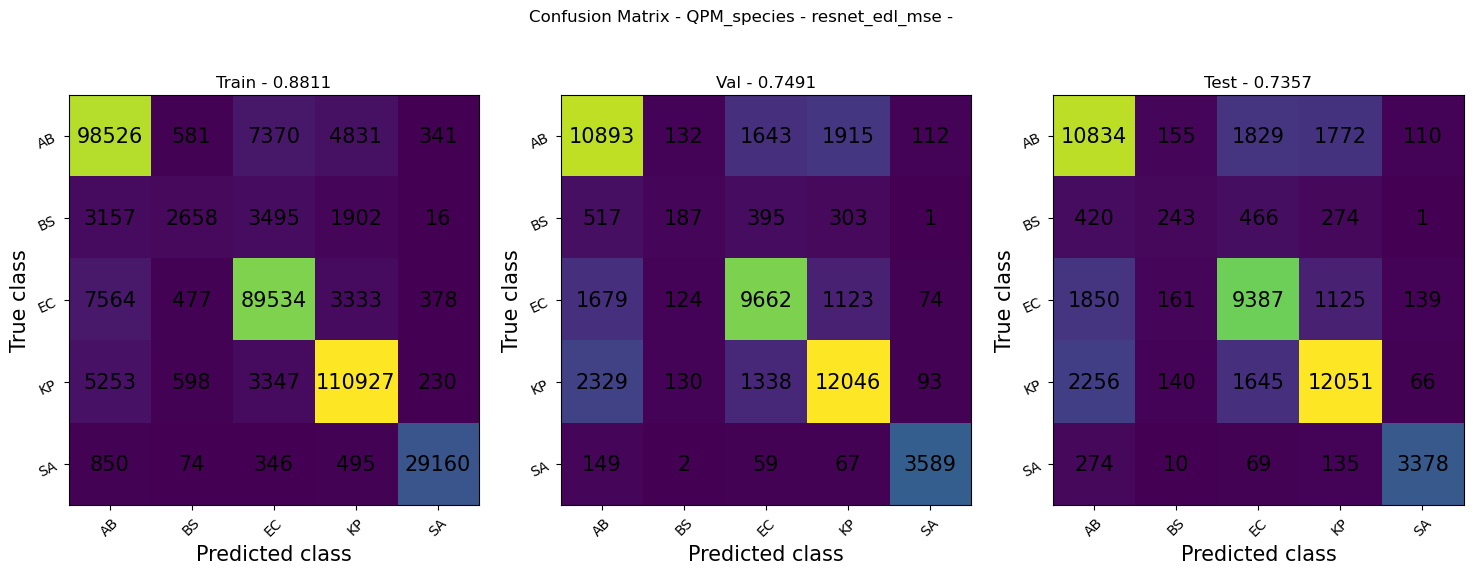

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(48790, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(48790, 2) (0, 2)


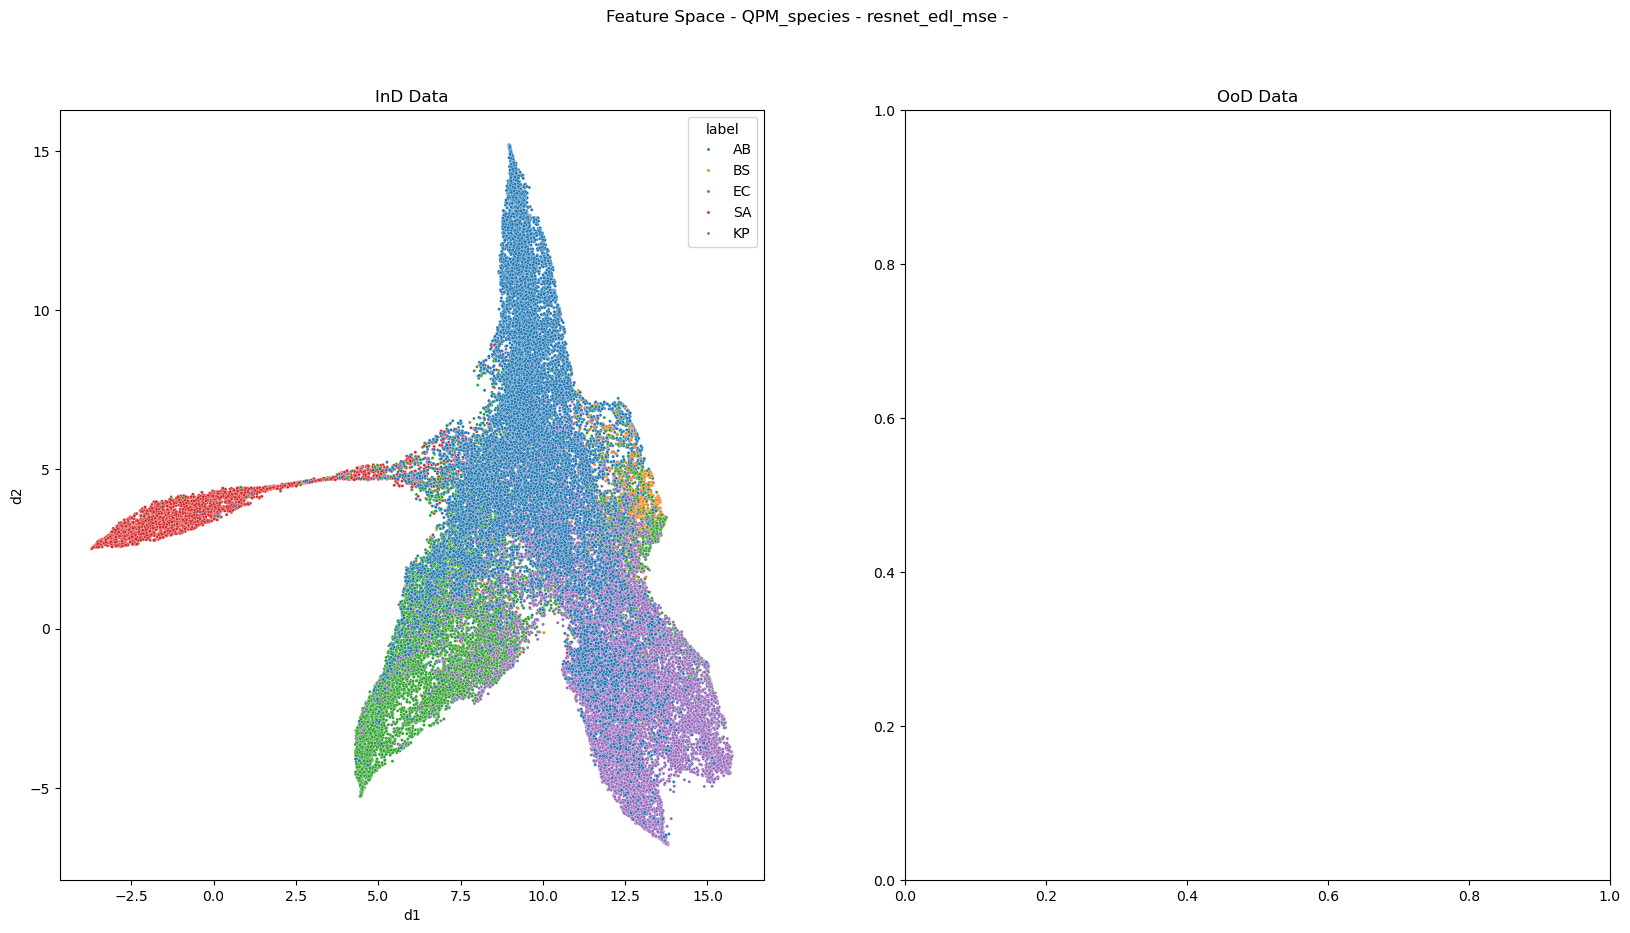

In [13]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

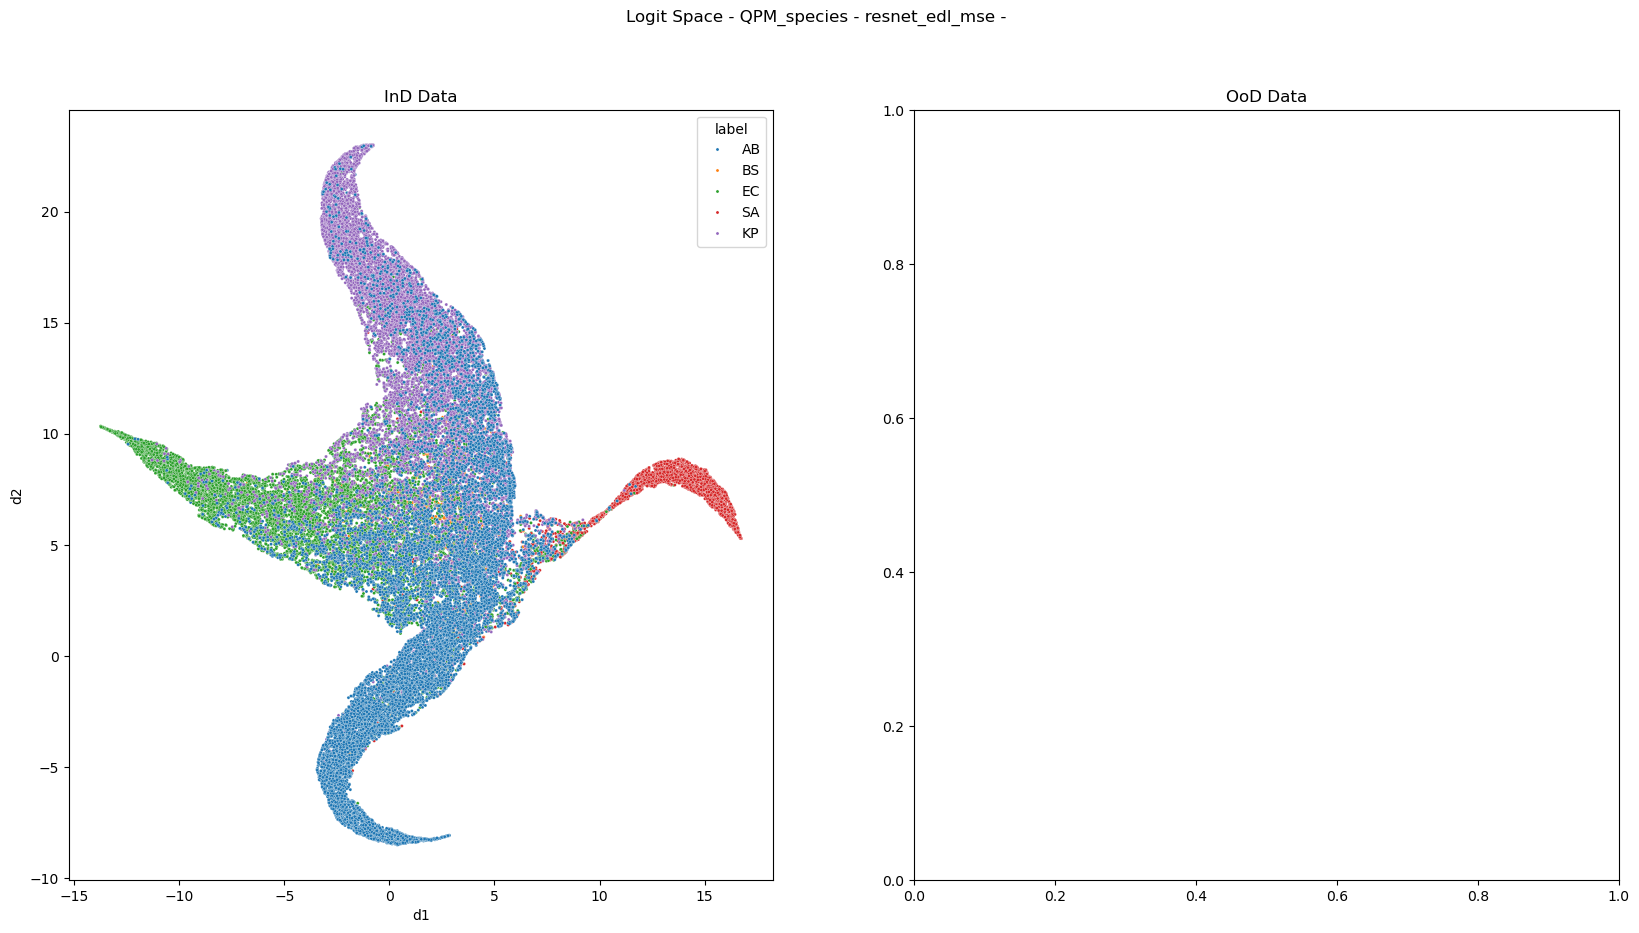

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

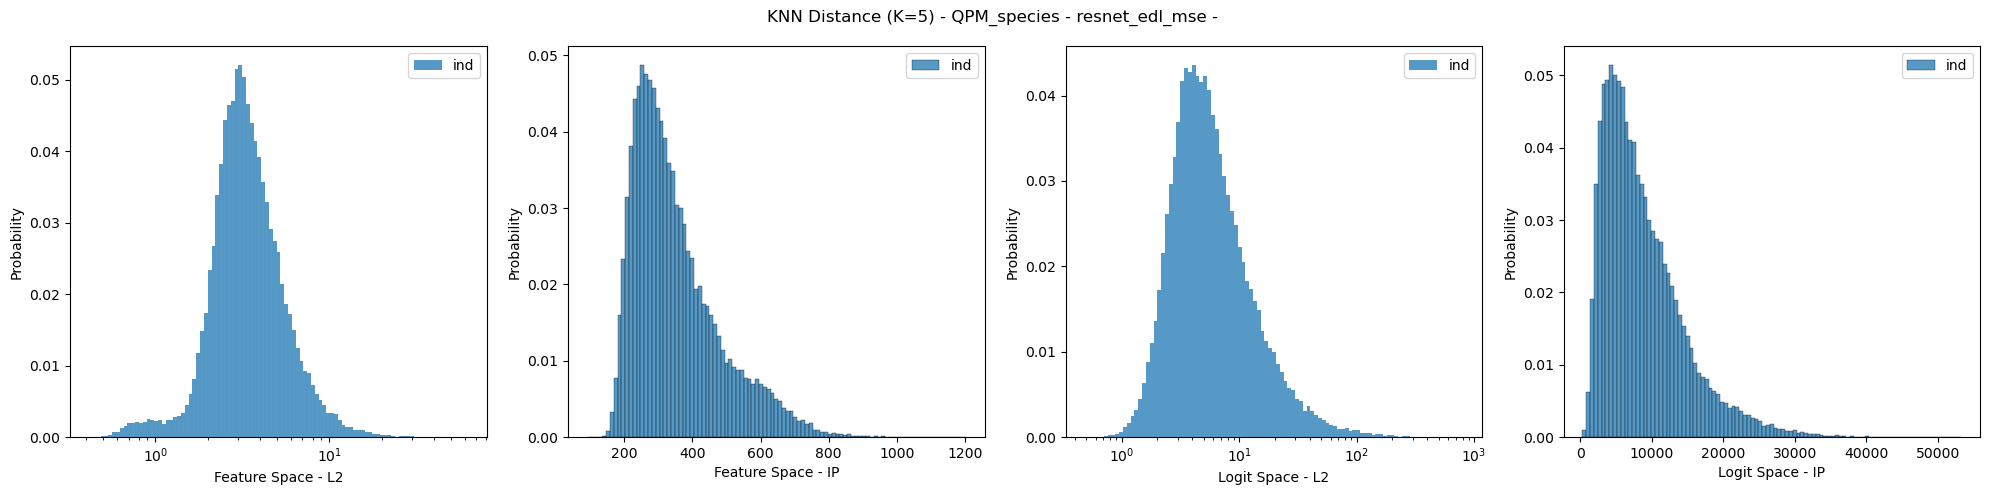

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

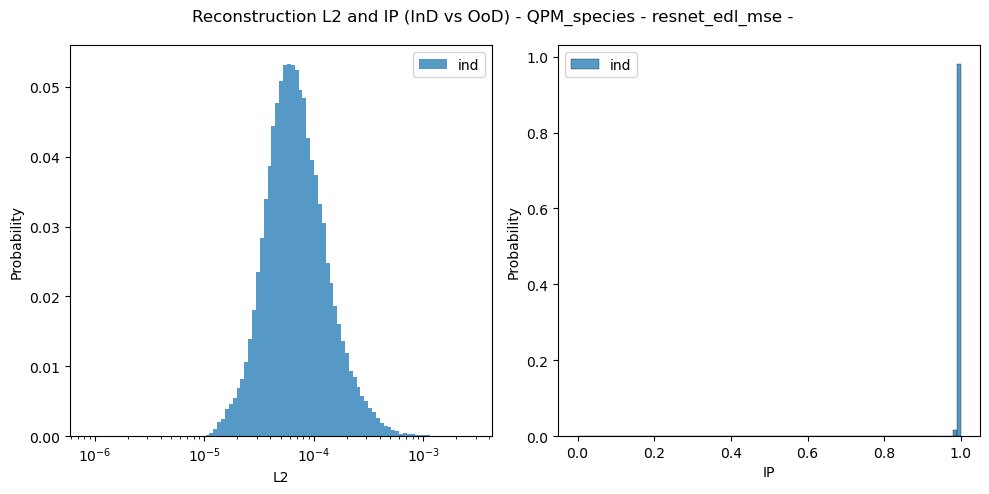

In [16]:
# plot reconstruction error of ind and ood data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_rcn.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_rcn.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

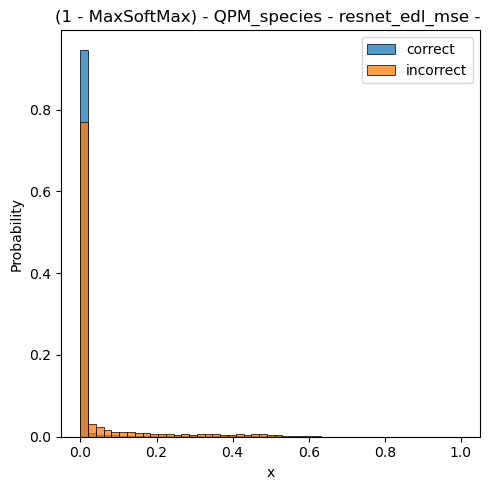

In [17]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

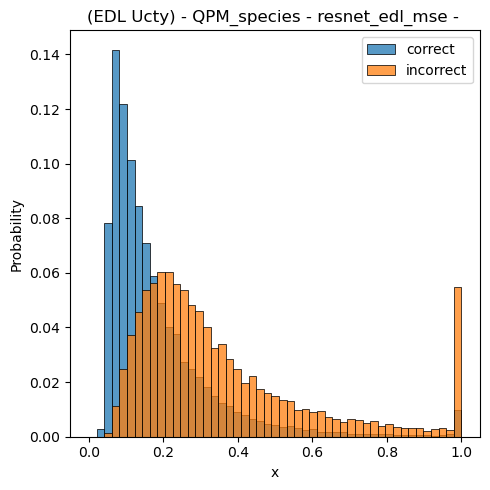

In [18]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data
K = ind_lgt.shape[-1]
ind_belief = np.clip(ind_lgt, 0, None)
ind_pred = ind_lgt.argmax(-1)
ind_prob = ind_belief / (ind_belief.sum(-1, keepdims=True) + K)
ind_ucty = K / (ind_belief.sum(-1) + K)

if ood_str:
    ood_belief = np.clip(ood_lgt, 0, None)
    ood_pred = ood_lgt.argmax(-1)
    ood_prob = ood_belief / (ood_belief.sum(-1, keepdims=True) + K)
    ood_ucty = K / (ood_belief.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()